# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /home/adrien/.local/lib/python3.8/site-packages (1.7.0+cu110)
Requirement already up-to-date: torchvision in /home/adrien/.local/lib/python3.8/site-packages (0.8.1+cu110)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-2aifhh6r
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-2aifhh6r
  Created wheel for fvcore: filename=fvcore-0.1.2-py3-none-any.whl size=48498 sha256=0656d30d37c1b264fcc66a9c78612e49a848bf174874a3d7341c5d2584704fb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-g3ets2zh/wheels/1c/a9/3c/ff2edce1a1295c72dfff759833097cb1d7713d2f09672d4dd1
Successfully built fvcore


'1.7.0+cu110'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///home/adrien/Desktop/Object-Detection-and-Image-Segmentation-with-Detectron2/detectron2_repo
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.3
    Uninstalling detectron2-0.3:
      Successfully uninstalled detectron2-0.3
  Running setup.py develop for detectron2


## start here if local

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2

import datetime, os
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
 #clean outputs for tensorboard
!rm output/events.*
!rm output/metrics*
!rm output/*
#%load_ext tensorboard
#!tensorboard --logdir ./output & > /dev/null
#%reload_ext tensorboard

rm: cannot remove 'output/events.*': No such file or directory
rm: cannot remove 'output/metrics*': No such file or directory
rm: cannot remove 'output/*': No such file or directory


# Train on a custom COCO dataset
In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.


Download the dataset if you are running on google colab

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive/')
    !unzip -o /content/drive/MyDrive/AI/dataset.zip > /dev/null
else:
    print("not running in google colaboratory")

not running in google colaboratory


Register the dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
# main one : 
register_coco_instances("cars_train", {}, "../comma200/comma200_coco.json", "../comma200/train")
register_coco_instances("cars_val", {}, "../comma200/comma200_coco.json", "../comma200/val")

# tests :
#register_coco_instances("cars", {}, "../save.json", "../bdd100k_images/bdd100k/images/100k/train/")
#register_coco_instances("cars_val", {}, "../comma200/comma200_coco.json", "../comma200/")
#register_coco_instances("cars", {}, "../convert_bdd100k_to_coco_format/save.json", "../bdd100k_images/bdd100k/images/100k/train/")

In [ ]:
car_train_metadata = MetadataCatalog.get("cars_train")
dataset_dicts = DatasetCatalog.get("cars_train")

WARNING [12/03 21:40:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/03 21:40:23 d2.data.datasets.coco]: Loaded 201 images in COCO format from ../comma200/comma200_coco.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



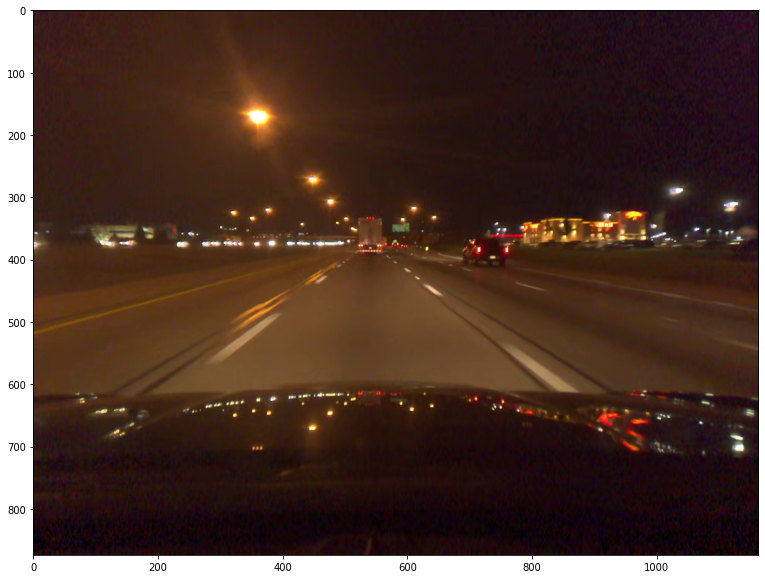

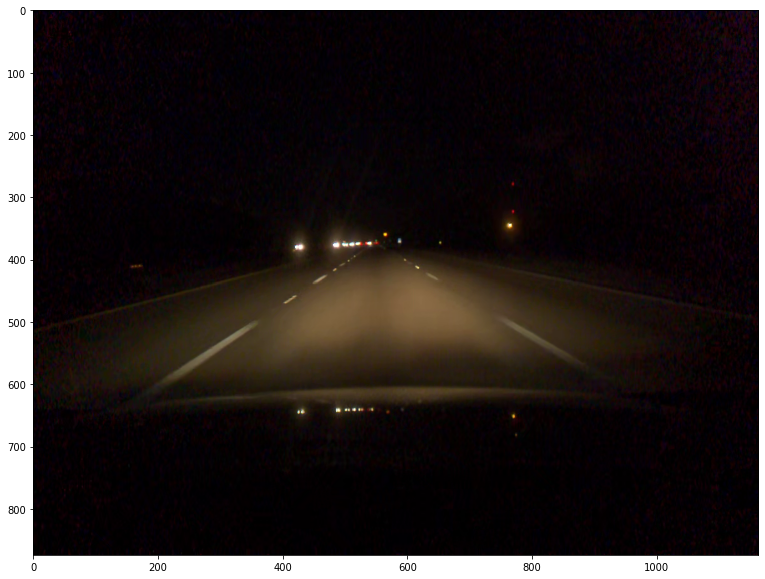

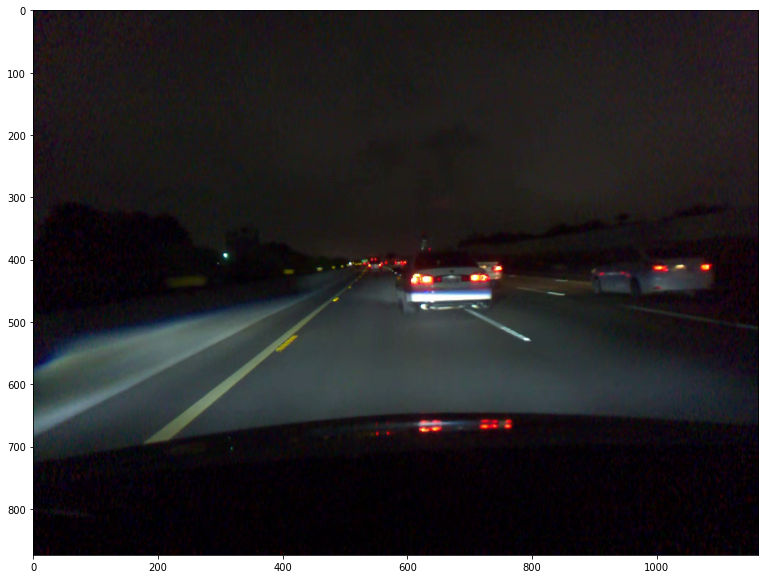

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
      img = cv2.imread(d["file_name"])
      visualizer = Visualizer(img[:, :, ::-1], metadata=car_train_metadata, scale=1)
      vis = visualizer.draw_dataset_dict(d)
      plt.figure(figsize = (13,13))
      plt.imshow(vis.get_image())


Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the car_train_metadata dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("cars_train",)
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.DATASETS.TEST = () #"cars_val"   # no metrics implemented for this dataset
#cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02 #default : 0.02
cfg.SOLVER.MAX_ITER = 500    #default : 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # default 128 faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/03 21:40:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[12/03 21:40:28 d2.engine.train_loop]: Starting training from iteration 0


/home/adrien/Desktop/Object-Detection-and-Image-Segmentation-with-Detectron2/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/adrien/Desktop/Object-Detection-and-Image-Segmentation-with-Detectron2/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/adrien/Desktop/Object-Detection-and-Image-Segmentation-with-Detectron2/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of n

[12/03 21:40:33 d2.utils.events]:  eta: 0:02:01  iter: 19  total_loss: 2.73  loss_cls: 1.313  loss_box_reg: 0.3574  loss_mask: 0.6762  loss_rpn_cls: 0.09043  loss_rpn_loc: 0.05082  time: 0.2553  data_time: 0.0108  lr: 0.00039962  max_mem: 2398M
[12/03 21:40:38 d2.utils.events]:  eta: 0:01:53  iter: 39  total_loss: 1.592  loss_cls: 0.5407  loss_box_reg: 0.387  loss_mask: 0.4955  loss_rpn_cls: 0.08134  loss_rpn_loc: 0.05875  time: 0.2491  data_time: 0.0035  lr: 0.00079922  max_mem: 2430M
[12/03 21:40:43 d2.utils.events]:  eta: 0:01:49  iter: 59  total_loss: 1.371  loss_cls: 0.4581  loss_box_reg: 0.4438  loss_mask: 0.3339  loss_rpn_cls: 0.05093  loss_rpn_loc: 0.06306  time: 0.2509  data_time: 0.0043  lr: 0.0011988  max_mem: 2725M
[12/03 21:40:49 d2.utils.events]:  eta: 0:01:45  iter: 79  total_loss: 1.018  loss_cls: 0.2785  loss_box_reg: 0.4052  loss_mask: 0.1999  loss_rpn_cls: 0.03889  loss_rpn_loc: 0.06612  time: 0.2522  data_time: 0.0035  lr: 0.0015984  max_mem: 2725M
[12/03 21:40:54 d

Now, we perform inference with the trained model on the car_train_metadata dataset. First, let's create a predictor using the model we just trained:



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("cars", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 15):    
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                       metadata=car_train_metadata, 
                       scale=1, 
                       instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize = (13,13))
        plt.imshow(v.get_image())

In [ ]:
car_train_metadata

namespace(name='cars_train',
          json_file='../comma200/comma200_coco.json',
          image_root='../comma200/train',
          evaluator_type='coco',
          thing_classes=['my car (ego)',
                         'car',
                         'sign',
                         'lane markings',
                         'truck',
                         'trafic light',
                         'person',
                         'crosswalk'],
          thing_dataset_id_to_contiguous_id={0: 0,
                                             1: 1,
                                             2: 2,
                                             3: 3,
                                             4: 4,
                                             5: 5,
                                             6: 6,
                                             7: 7})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.07,fps:13.38
